# Topic modeling Using Bigrams and Trigrams

In [1]:
import awswrangler as wr

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
import en_core_web_md
import gensim
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/.local/lib/python3.10/site-packages/joblib/backports.py:22: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils  # noqa


In [2]:
df = wr.s3.read_csv('s3://siads696-wi23-steam-data/clean_data/reviews_clean_new.csv')

In [3]:
df.head()

,app_id,app_name,review_score,review_votes,num_words,clean_tokens
0,107410,Arma 3,1,1,179,spend several year army get say game spot trai...
1,107410,Arma 3,1,1,40,have accumulate hour game certainly recommend ...
2,107410,Arma 3,1,0,59,join exile sever find year old kid kid say m l...
3,107410,Arma 3,1,1,34,hour game say full validity game ruin life lik...
4,107410,Arma 3,1,0,9,game make realize fps playable


In [4]:
df.isna().sum()

app_id            0
app_name          0
review_score      0
review_votes      0
num_words         0
clean_tokens    150
dtype: int64

In [5]:
df.shape

(575223, 6)

In [6]:
df.dropna(inplace=True)

## 1. Train on small dataset
### Start with 100K dataset for testing and tuning

In [7]:
df_small = df.sample(100000, random_state=42)

### Form a list of words for each review
From the tokenization and lemmatization that was done, some words resulted in a length of one character such as "s" or "m" so we are only going to keep words with a length of 2 characters or more.

In [8]:
data_words = df_small['clean_tokens'].map(lambda x: [word for word in x.split() if len(word) >=2])

## Bigrams and Trigrams
The next thing we're going to do is create bigrams and trigrams using gensim Phraser. We first start by creating bigrams and afterwards, we take the bigram phrases and we're going to index `data_words` and find where there's overlap between bigrams and other words to figure out when three words are used as a phrase.

The parameters used to create bigram and trigram phrases are:
- `min_count:` the number of times two words need to be used collectively.
- `threshold:` determines the number of phrases that are found and a higher threshold leads to fewer phrases.

In [9]:
bigram = gensim.models.Phrases(data_words, min_count=10, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Next we create a function to make bigrams from the text in each review and a function to make trigrams from the bigrams that were created.

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
# Form Trigrams using data_words_bigrams
data_words_bigrams_trigrams = make_trigrams(data_words_bigrams)

In [11]:
# review the first few reviews for bigrams and trigrams
for i in range(1,10):
    print(data_words_bigrams_trigrams[i])

['use', 'play', 'too', 'much']
['really', 'cool', 'play', 'friend', 'forget', 'free', 'game']
['good', 'game', 'worth', 'wait', 'worth', 'play']
['only', 'play', 'bank', 'ct', 'get', 'load', 'more', 'slot', 'unbalanced', 'also', 'play', 'competitive']
['time', 'review', 'millionaire', 'yet', 'afford', 'deffect', 'free', 'drill']
['start', 'say', 'game', 'good', 'game', 'ever', 'play', 'recommend', 'steam', 'friend', 'kick_butt', 'together', 'unique', 'game', 'past', 'few', 'hotfixe', 'game', 'quality', 'drop', 'dramatically', 'new', 'change', 'mad', 'celephon', 'update', 'exact', 'so', 'many', 'bug', 'random', 'glitch', 'slow', 'acurence', 'accompany', 'weapon', 'stat', 'change', 'other', 'drive', 'love', 'game', 'existence', 'seem', 'user', 'game', 'awhile', 'change', 'so', 'much', 'even', 'close', 'same', 'game', 'anymore', 'all', 'fun', 'play', 'anymore', 'wish', 'choose', 'make', 'next', 'update', 'more', 'closely', 'relate', 'regard']
['click', 'close', 'program', 'textbox', 'say'

### TF-IDF Model for Term Removal
In order to remove noise from our LDA model, we will use frequently occurring words since we are looking for words that have higher importance. There's no perfect solution and the removal of frequently used words requires a trial and error approach. TF-IDF is calculated by multiplying the term frequency with inverse document frequency and normalizing the results across the documents. The TF-IDF helps keep document specifid frequent words weight high and ensures that the most common words don't show up as key words.

In [12]:
# TF-IDF Removal
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_words_bigrams_trigrams)

texts = data_words_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0][:20])

# create TF-IDF model using the corpus and id2word dictionary
tfidf = TfidfModel(corpus, id2word = id2word)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)]


The threshold for the TF-IDF model will be 0.03 and we are going to look for words that occur within this threshold and if a word occurs with this frequency across the corpus then it's going to assume that the word does not provide much value since it occurs at such a high frequency.  There is a caveat, which is that some words that are important to the corpus may end up being dropped.

A new corpus will be returned that has all the high frequency words removed.

In [13]:
low_value = 0.03
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [14]:
# review length of dictionary
len(id2word)

42492

### Finding the optimal number of topics
One of the most popular coherence metrics is called cv. It creates content vectors of words using their co-occurrences and, after that, calculates the score using normalized pointwise mutual information (NPMI) and the cosine similarity. Another popular coherence score is umass which calculates how often two words appear together in the corpus and the greater the number the better its cohernece score. This measure isn't symmetric, which allows us to calculate the global coherence of the topic as the average pairwise coherence scores on the top N words which describe the topic.

For our model we are going to be using the cv coherence metric.

#### Use parallelized Latent Dirichlet Allocation
Given the large dataset, we will use `LdaMulticore` to parallelize the training job. The EC2 instance that's being used for training is a c5a.4xlarge which has 16 CPU cores and 32GB of memory. More information on the ldamulticore can be found at: https://radimrehurek.com/gensim/models/ldamulticore.html

In [15]:
num_vcpu = 16

coherence = []
for k in range(5,15):
    print('Round: '+str(k))
    Lda = gensim.models.ldamulticore.LdaMulticore
    ldamodel = Lda(corpus=corpus, num_topics=k,
                   id2word = id2word, passes=10,
                   iterations=200, chunksize = 50000,
                   eval_every = None,
                   workers=num_vcpu-1)
    
    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=texts,\
         dictionary=id2word, coherence='c_v')   
                                                
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14


In [16]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

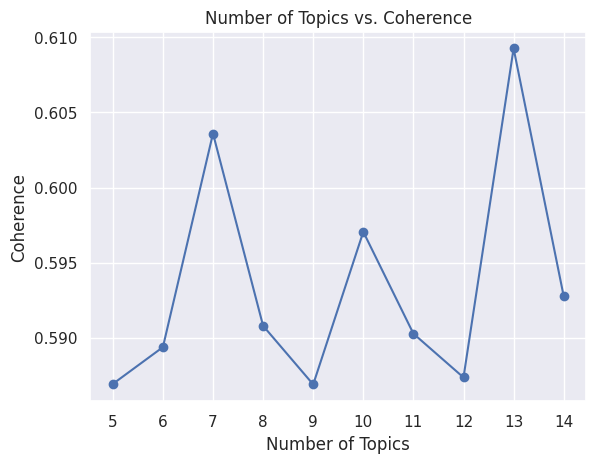

In [17]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

## Vizualizing the Data
The LDA model is now going to be built using 7 topics. Below is information on the model parameters.
- Passes: The number of times model iterates through the whole corpus
- Iterations: The number of iterations the model trains on each pass
- Chunk size: Number of rows that are taken to train the model each

In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, 
                                            id2word = id2word,
                                            num_topics = 7,
                                            random_state = 42,
                                            update_every = 1,
                                            iterations=200,
                                            eval_every = None,
                                            chunksize = 5000,
                                            passes = 40,
                                            alpha = 'auto')

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = 'mmds', R = 30)

/home/ubuntu/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [22]:
pyLDAvis.display(vis)

## 2. Training on Full Dataset

In [23]:
data_words = df['clean_tokens'].map(lambda x: [word for word in x.split() if len(word) >=2])

### Form Bigrams and Trigrams

In [26]:
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [27]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
# Form Trigrams using data_words_bigrams
data_words_bigrams_trigrams = make_trigrams(data_words_bigrams)

In [32]:
print(data_words_bigrams_trigrams[0])

['spend', 'several', 'year', 'army', 'get', 'say', 'game', 'spot', 'training', 'atmosphere', 'military', 'provide', 'love', 'difficult', 'game', 'love', 'different', 'feature', 'game', 'provide', 'easy', 'hit_target', 'assault_rifle', 'yard', 'real_life', 'game', 'seem', 'match', 'same', 'difficulty', 'fatigue', 'real', 'thing', 'seriously', 'hinder', 'accuracy', 'real_life', 'make', 'stop', 'catch_breath', 'run', 'too', 'far', 'carry', 'too', 'much', 'gear', 'hard', 'time', 'hit_target', 'enemy', 'stupid', 'great', 'vision', 'engage', 'enemy', 'yard_away', 'use', 'bush', 'cover', 'as', 'well', 'second', 'rush', 'move', 'ai', 'more', 'advanced', 'average', 'taliban', 'real_life', 'haha', 'give', 'love', 'military', 'videogame', 'one', 'definitely', 'favorite', 'time']


### TF-IDF Model

In [29]:
# TF-IDF Removal
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_words_bigrams_trigrams)

texts = data_words_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0][:20])

# create TF-IDF model using the corpus and id2word dictionary
tfidf = TfidfModel(corpus, id2word = id2word)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1)]


In [33]:
low_value = 0.03
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

### Build LDA Model for 10 topics

In [35]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, 
                                            id2word = id2word,
                                            num_topics = 10,
                                            random_state = 42,
                                            update_every = 1,
                                            iterations=200,
                                            eval_every = None,
                                            chunksize = 5000,
                                            passes = 40,
                                            alpha = 'auto')

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = 'mmds', R = 30)

/home/ubuntu/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [37]:
pyLDAvis.display(vis)